In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
btc_data = pd.read_csv('../BTC-USD.csv')
bnb_data = pd.read_csv('../BNB-USD.csv')

Đọc dữ liệu

In [3]:
data = pd.merge(btc_data, bnb_data, on='Date')
data.head()

,Date,Close-BTC,Close-BNB
0,1/1/2019,3843.520020,6.075273
1,1/2/2019,3943.409424,6.188613
2,1/3/2019,3836.741211,5.903535
3,1/4/2019,3857.717529,6.065138
4,1/5/2019,3845.194580,6.065543


In [4]:

# data = data.reset_index(drop=True) # Reset the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Close-BTC', 'Close-BNB']]
data = data.dropna() # Drop missing values

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(data))
test_size = int(0.2 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

1099
314
157


**<h3>Dự đoán ARIMAX 7-2-1</h3>**

In [5]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-BNB"]]
model = auto_arima(train_data["Close-BTC"], 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18575.954, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18575.808, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18575.830, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18575.227, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=18577.813, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.083 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1099
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -9286.614
Date:                Thu, 01 Jun 2023   AIC                          18575.227
Time:                        00:14:37   BIC                          18580.229
Sample:                    01-01-2019   HQIC                         18577.119
          

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data['Close-BTC'], 
 exog=train_exog,
 order=(0,1,0),
 enforce_invertibility=False, enforce_stationarity=False)

c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\diuai\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [7]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close-BTC'])
test_exog = test_data[['Close-BNB']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close-BTC'])
val_exog = val_data[['Close-BNB']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2022-01-04    46232.269759
2022-01-05    44649.387304
2022-01-06    44562.492754
2022-01-07    43319.221152
2022-01-08    42463.499620
                  ...     
2022-11-09    34493.124247
2022-11-10    36309.068215
2022-11-11    35613.484739
2022-11-12    35248.642622
2022-11-13    34967.577793
Freq: D, Name: predicted_mean, Length: 314, dtype: float64
             Close-BNB
Date                  
2022-11-14  278.578430
2022-11-15  276.874023
2022-11-16  272.081604
2022-11-17  267.911316
2022-11-18  273.919983
...                ...
2023-04-15  333.407288
2023-04-16  348.220917
2023-04-17  339.994110
2023-04-18  343.193451
2023-04-19  322.707520

[157 rows x 1 columns]
2022-01-04    35065.089444
2022-01-05    34981.947812
2022-01-06    34748.171763
2022-01-07    34544.743505
2022-01-08    34837.848601
                  ...     
2022-06-05    37739.662304
2022-06-06    38462.276845
2022-06-07    38060.970024
2022-06-08    38217.035113
2022-06-09    37217.723490
Freq: D, Name: predicted

In [234]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

prev_30_days_exog = data[len(data)-30:]
prev_30_days_exog = prev_30_days_exog['Close-ETH']




# Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = prev_30_days_exog) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-12-21    24743.129452
2021-12-22    23955.822506
2021-12-23    23905.076142
2021-12-24    23855.018440
2021-12-25    23859.378815
2021-12-26    23784.817027
2021-12-27    23495.902411
2021-12-28    22555.551741
2021-12-29    22447.395599
2021-12-30    22949.334901
2021-12-31    23976.701202
2022-01-01    24834.597175
2022-01-02    25047.

Validation RMSE: 14554.77
Testing RMSE: 10338.78
Validation MAPE: 70.94%
Testing MAPE: 0.38217715358929527


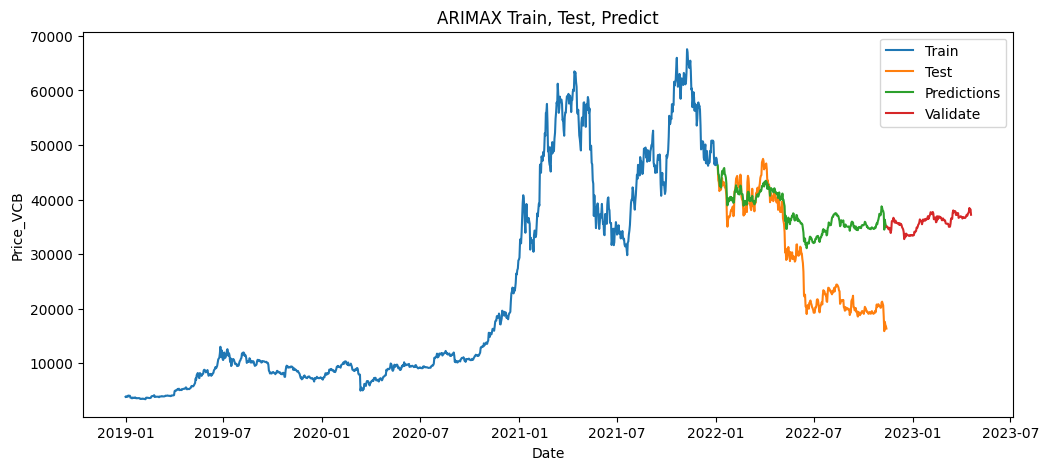

In [8]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print(f"Validation RMSE: {valid_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print(f"Validation MAPE: {valid_mape* 100:.2f}%")
print('Testing MAPE:', test_mape)



# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Price_VCB');
plt.xlabel('Date');
plt.title('ARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close-BTC'])
plt.plot(test_data.index, test_data['Close-BTC'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
#plt.plot(next_30_days_index,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()

**<h3>Dự đoán ARIMAX 6-3-1</h3>**

In [236]:

# data = data.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(data))
test_size = int(0.3 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]
print(len(train_data))
print(len(test_data))
print(len(val_data))

930
465
156


In [237]:
from pmdarima.arima import auto_arima
train_exog = train_data[["Close-ETH"]]
model = auto_arima(train_data.Close, 
                      test='adf',       # use adftest to find      
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,  
                      stepwise=True,
                      exogenous= train_exog)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15463.160, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15470.836, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15465.152, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15466.259, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15469.681, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15461.203, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15461.041, Time=0.15 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15461.745, Time=0.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15464.148, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15463.203, Time=1.68 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15459.907, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15465.258, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=15459.475, Time=0.44 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15463.029, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0

In [238]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train_data.Close, 
 exog=train_exog,
 order=(2,1,2),
 enforce_invertibility=False, enforce_stationarity=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [239]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
test_exog = test_data[['Close-ETH']]
model_fit = model.fit()
# y_pred = model.predict(n_periods=len(y_test))
y_pred = model_fit.forecast(steps=len(y_test), exog=test_exog)
print(y_pred)

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
val_exog = val_data[['Close-ETH']]
print(val_exog)
y_pred_val =  model_fit.forecast(steps=len(y_val), exog=val_exog)
print(y_pred_val)

2021-07-19    31018.801187
2021-07-20    30741.519200
2021-07-21    32752.499035
2021-07-22    33102.019158
2021-07-23    34088.847704
                  ...     
2022-10-22    26163.705888
2022-10-23    26649.313318
2022-10-24    26467.032179
2022-10-25    27619.764710
2022-10-26    28656.246427
Freq: D, Name: predicted_mean, Length: 465, dtype: float64
              Close-ETH
Date                   
2022-10-27  1514.374878
2022-10-28  1555.477905
2022-10-29  1619.698486
2022-10-30  1590.783325
2022-10-31  1572.714478
...                 ...
2023-03-27  1715.460815
2023-03-28  1772.785645
2023-03-29  1793.001831
2023-03-30  1792.737183
2023-03-31  1822.022095

[156 rows x 1 columns]
2021-07-19    28025.768469
2021-07-20    28448.907771
2021-07-21    29084.125117
2021-07-22    28809.717378
2021-07-23    28634.171669
                  ...     
2021-12-17    30127.400633
2021-12-18    30693.801445
2021-12-19    30893.548536
2021-12-20    30890.933769
2021-12-21    31180.284822
Freq: D, Na

In [240]:
import datetime
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
print(last_index)
# last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
next_30_days_index = pd.date_range(start=last_index + datetime.timedelta(days=1), periods=30, freq='D')
print(next_30_days_index)
# Create an array of 30 consecutive integers starting from last_index
# x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
x_next_30_days = np.array(next_30_days_index).reshape(-1, 1)

prev_30_days_exog = data[len(data)-30:]
prev_30_days_exog = prev_30_days_exog['Close-ETH']




# Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(n_periods=len(x_next_30_days)) 
y_next_30_days = model_fit.forecast(steps=len(x_next_30_days), exog = prev_30_days_exog) 

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

2023-03-31 00:00:00
DatetimeIndex(['2023-04-01', '2023-04-02', '2023-04-03', '2023-04-04',
               '2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08',
               '2023-04-09', '2023-04-10', '2023-04-11', '2023-04-12',
               '2023-04-13', '2023-04-14', '2023-04-15', '2023-04-16',
               '2023-04-17', '2023-04-18', '2023-04-19', '2023-04-20',
               '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
               '2023-04-25', '2023-04-26', '2023-04-27', '2023-04-28',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', freq='D')
Predicted closing prices for the next 30 days:
2021-07-19    29339.332479
2021-07-20    28584.169481
2021-07-21    28562.683816
2021-07-22    28549.714975
2021-07-23    28581.648695
2021-07-24    28535.704172
2021-07-25    28264.345913
2021-07-26    27327.589144
2021-07-27    27237.535794
2021-07-28    27770.602969
2021-07-29    28838.108995
2021-07-30    29731.511244
2021-07-31    29963.

Validation RMSE: 7219.256342572458
Testing RMSE: 4625.047628471628
Validation MAPE: 0.3640180025247486
Testing MAPE: 0.1299707655672918


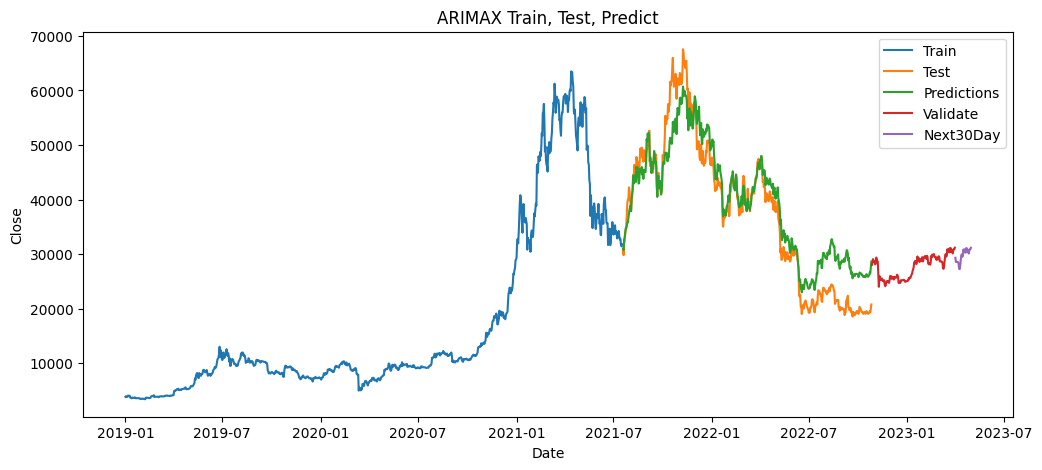

In [242]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_mape = np.mean(np.abs(y_pred_val - y_val)/np.abs(y_val))  # MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))  # MAPE
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)



# 9.Vẽ hình
plt.figure(figsize=(12,5), dpi=100)
plt.ylabel('Close');
plt.xlabel('Date');
plt.title('ARIMAX Train, Test, Predict')
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
# plt.plot(last_data,y_next_30_days)
plt.plot(next_30_days_index,y_next_30_days)

plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()